# CSE 151B Kaggle Competition

In [303]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import ast
import random
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from datetime import datetime
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from scipy.spatial.distance import cdist
from math import radians, sin, cos, sqrt, atan2
import scipy.stats as stats
import geopandas as gpd
from shapely.geometry import LineString
from sklearn.preprocessing import OneHotEncoder
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical
import folium
import lightgbm as lgb
import pickle

In [2]:
df_tr = pd.read_csv("train.csv")

In [3]:
torch.cuda.is_available()

True

# EDA and Feature Engineering

In [4]:
# dropping small amount of data with incomplete gps data since there isn't much
num_missing = df_tr['MISSING_DATA'].value_counts()[True]
percent = 100*(df_tr['MISSING_DATA'].value_counts()[True] / len(df_tr))
print('Percentage of MISSING_DATA = True is {:.5f}'.format(percent))
df_tr = df_tr[df_tr['MISSING_DATA']==False]

Percentage of MISSING_DATA = True is 0.00058


In [5]:
df_tr["DAY_TYPE"].describe() # Only has one unique value so we can drop the column
df_tr.drop('DAY_TYPE', axis=1, inplace=True)

In [6]:
is_duplicate = df_tr.duplicated(keep=False)

# Get the duplicate rows
duplicate_rows = df_tr[is_duplicate]

print("Duplicate rows:")
print(duplicate_rows)
print("Number of duplicate rows")
#drop them
df_tr.drop_duplicates(inplace=True)

Duplicate rows:
                     TRIP_ID CALL_TYPE  ORIGIN_CALL  ORIGIN_STAND   TAXI_ID  \
302435   1378607552620000403         C          NaN           NaN  20000403   
302441   1378607552620000403         C          NaN           NaN  20000403   
998727   1391416612620000196         C          NaN           NaN  20000196   
998728   1391416612620000196         C          NaN           NaN  20000196   
1304114  1397172149620000454         C          NaN           NaN  20000454   
1304115  1397172149620000454         C          NaN           NaN  20000454   

          TIMESTAMP  MISSING_DATA  \
302435   1378607552         False   
302441   1378607552         False   
998727   1391416612         False   
998728   1391416612         False   
1304114  1397172149         False   
1304115  1397172149         False   

                                                  POLYLINE  
302435                                                  []  
302441                                          

In [7]:
def parse_time(x):
  # We are using python's builtin datetime library
  # https://docs.python.org/3/library/datetime.html#datetime.date.fromtimestamp
  # Each x is essentially a 1 row, 1 column pandas Series
    dt = datetime.fromtimestamp(x["TIMESTAMP"])
    return dt.year, dt.month, dt.day, dt.hour, dt.weekday()

# Because we are assigning multiple values at a time, we need to "expand" our computed (year, month, day, hour, weekday) tuples on 
# the column axis, or axis 1
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.apply.html
df_tr[["YR", "MON", "DAY", "HR", "WK"]] = df_tr[["TIMESTAMP"]].apply(parse_time, axis=1, result_type="expand")

In [8]:
def calculate_haversine_distance(lon1, lat1, lon2, lat2):
    # Convert coordinates from degrees to radians
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    distance = 6371 * c  
    return distance

In [9]:
# Matching Test
# df_tr = df_tr[df_tr['YR'] != 2014] # 2014 doesn't have months used in public test set
# df_tr = df_tr[df_tr['MON'] >= 8] # public test set starts from August

In [10]:
# Estimating trip length from Polyline
def polyline_to_trip_duration(polyline):
    return max(polyline.count("[") - 2, 0) * 15

# This code creates a new column, "LEN", in our dataframe. The value is
# the (polyline_length - 1) * 15, where polyline_length = count("[") - 1
df_tr["LEN"] = df_tr["POLYLINE"].apply(polyline_to_trip_duration)

In [11]:
# checking how many trips have time of 0 and dropping
percent_zero = 100*(len(df_tr[df_tr['LEN'] == 0]) / len(df_tr))
print("Percentage of trips with zero travel time is {:.2f}%".format(percent_zero))
df_tr = df_tr[df_tr["LEN"]!= 0] #dropping any trips with travel time of zero

Percentage of trips with zero travel time is 2.13%


In [12]:
def categorize_hour(hour):
    if hour < 12:  # Morning (0-11)
        return 'MORNING'
    elif hour >= 12 and hour < 18:  # Afternoon (12-17)
        return 'AFTERNOON'
    else:  # Evening (18-23)
        return 'EVENING'
    
def get_day_category(day, month, year):
    date = datetime(year=year, month=month, day=day)    
    holidays = [
        (1, 1),     # New Year's Day
        (4, 25),    # Liberation Day
        (5, 1),     # Labor Day
        (6, 10),    # Portugal Day
        (8, 15),    # Assumption Day
        (10, 5),    # Republic Day
        (11, 1),    # All Saints' Day
        (12, 1),    # Restoration of Independence
        (12, 25)    # Christmas Day
    ]
    if (day, month) in holidays:
        return 'HOLIDAY'
    elif date.weekday() >= 5:
        return 'WK_END'
    else:
        return 'WK_DAY'

In [13]:
df_tr.drop('MISSING_DATA', axis=1, inplace=True)
df_tr.drop('TRIP_ID', axis=1, inplace=True)
df_tr.head()

,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,POLYLINE,YR,MON,DAY,HR,WK,LEN
0,C,NaN,NaN,20000589,1372636858,"[[-8.618643,41.141412],[-8.618499,41.141376],[...",2013,7,1,0,0,330
1,B,NaN,7.0,20000596,1372637303,"[[-8.639847,41.159826],[-8.640351,41.159871],[...",2013,7,1,0,0,270
2,C,NaN,NaN,20000320,1372636951,"[[-8.612964,41.140359],[-8.613378,41.14035],[-...",2013,7,1,0,0,960
3,C,NaN,NaN,20000520,1372636854,"[[-8.574678,41.151951],[-8.574705,41.151942],[...",2013,7,1,0,0,630
4,C,NaN,NaN,20000337,1372637091,"[[-8.645994,41.18049],[-8.645949,41.180517],[-...",2013,7,1,0,0,420


In [14]:
#df_tr.groupby('ORIGIN_CALL', dropna=False)['LEN'].agg(['mean', 'std', 'count']).sort_values(by='count', ascending=False).head(50)
#df_tr.groupby('ORIGIN_STAND', dropna=False)['LEN'].agg(['mean', 'std', 'count']).sort_values(by='count', ascending=False).head(50)

In [15]:
# Do One-hot encoding for CALL_TYPE column
# df_tr['AVERAGE_CALL'] = df_tr.groupby('CALL_TYPE')['LEN'].transform('mean')
# gd1 = df_tr.groupby('CALL_TYPE')['LEN'].mean()
# average_len_by_call_type = gd1.to_dict()
df_tr = pd.get_dummies(df_tr, columns=['CALL_TYPE'], prefix=['CALL_TYPE'])

/tmp/ipykernel_1029/2426100216.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df_tr.corr()


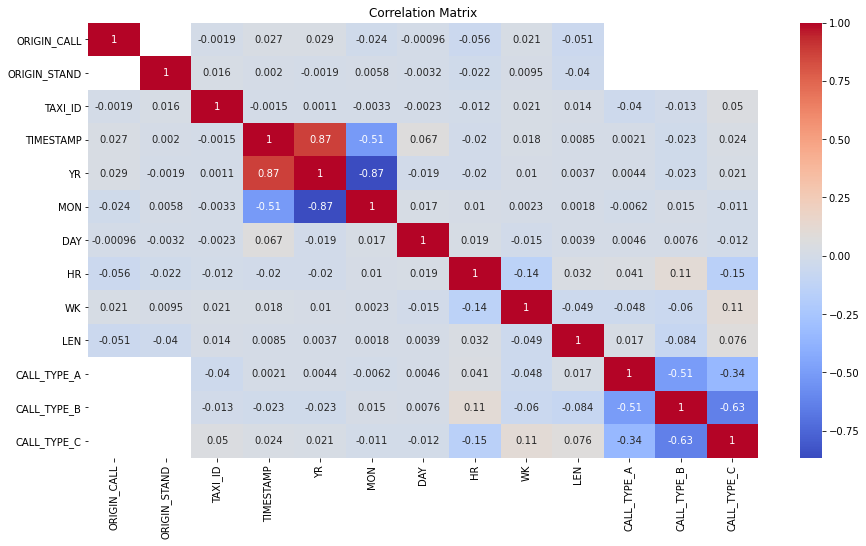

In [16]:
correlation_matrix = df_tr.corr()
plt.figure(figsize=(15, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [17]:
def encode_hour(hour):
    hour_radians = hour * 2 * np.pi / 24
    return np.sin(hour_radians), np.cos(hour_radians)
def encode_day(day):
    day_rad = hour * 2 * np.pi / 31
    return np.sin(day_rad), np.cos(hour_radians)
def encode_mon(hour):
    hour_radians = hour * 2 * np.pi / 12
    return np.sin(hour_radians), np.cos(hour_radians)
def encode_wk(wk):
    hour_radians = hour * 2 * np.pi / 7
    return np.sin(hour_radians), np.cos(hour_radians)

In [18]:
df_tr['SIN_HR_ANG'],  df_tr['COS_HR_ANG']= encode_hour(df_tr['HR'])
df_tr['SIN_MON_ANG'],  df_tr['COS_MON_ANG']= encode_hour(df_tr['MON'])
df_tr['SIN_DAY_ANG'],  df_tr['COS_DAY_ANG']= encode_hour(df_tr['DAY'])
df_tr['SIN_WK_ANG'],  df_tr['COS_WK_ANG']= encode_hour(df_tr['WK'])

In [19]:
df_tr['TAXI_ID'].nunique() # can't get average time by taxi_id if I drop 2014

442

In [20]:
# statistics of non_categorical columns
df_tr.head()

,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,POLYLINE,YR,MON,DAY,HR,WK,...,CALL_TYPE_B,CALL_TYPE_C,SIN_HR_ANG,COS_HR_ANG,SIN_MON_ANG,COS_MON_ANG,SIN_DAY_ANG,COS_DAY_ANG,SIN_WK_ANG,COS_WK_ANG
0,NaN,NaN,20000589,1372636858,"[[-8.618643,41.141412],[-8.618499,41.141376],[...",2013,7,1,0,0,...,0,1,0.0,1.0,0.965926,-0.258819,0.258819,0.965926,0.0,1.0
1,NaN,7.0,20000596,1372637303,"[[-8.639847,41.159826],[-8.640351,41.159871],[...",2013,7,1,0,0,...,1,0,0.0,1.0,0.965926,-0.258819,0.258819,0.965926,0.0,1.0
2,NaN,NaN,20000320,1372636951,"[[-8.612964,41.140359],[-8.613378,41.14035],[-...",2013,7,1,0,0,...,0,1,0.0,1.0,0.965926,-0.258819,0.258819,0.965926,0.0,1.0
3,NaN,NaN,20000520,1372636854,"[[-8.574678,41.151951],[-8.574705,41.151942],[...",2013,7,1,0,0,...,0,1,0.0,1.0,0.965926,-0.258819,0.258819,0.965926,0.0,1.0
4,NaN,NaN,20000337,1372637091,"[[-8.645994,41.18049],[-8.645949,41.180517],[-...",2013,7,1,0,0,...,0,1,0.0,1.0,0.965926,-0.258819,0.258819,0.965926,0.0,1.0


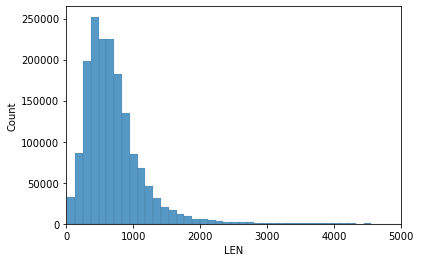

In [21]:
sns.histplot(data=df_tr, x="LEN", bins=500)
plt.xlim(0, 5000)
plt.show() # right skewed histogram->peak at around ~400

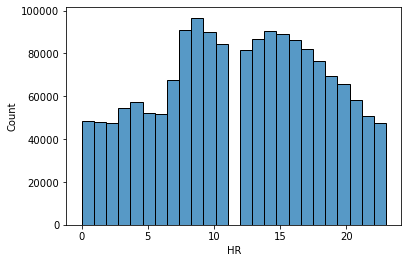

In [22]:
sns.histplot(data=df_tr, x="HR", bins=25)
plt.show() # right skewed histogram->peak at around ~400

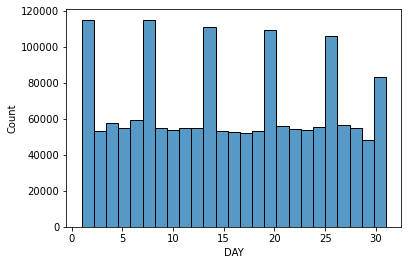

In [23]:
sns.histplot(data=df_tr, x="DAY", bins=25)
plt.show() # right skewed histogram->peak at around ~400

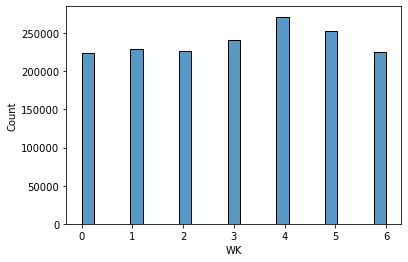

In [24]:
sns.histplot(data=df_tr, x="WK", bins=25)
plt.show() # right skewed histogram->peak at around ~400

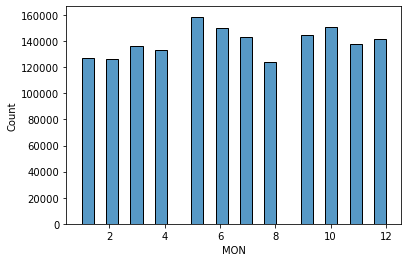

In [25]:
sns.histplot(data=df_tr, x="MON", bins=25)
plt.show() # right skewed histogram->peak at around ~400

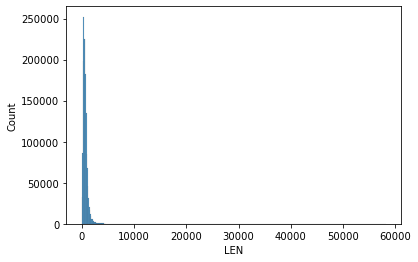

In [101]:
sns.histplot(data=df_tr, x="LEN", bins=500)
plt.show() # right skewed histogram->peak at around ~400

In [ ]:
# Clipping outliers
upper_lim = df_tr['LEN'].quantile(0.99) 
lower_lim = df_tr['LEN'].quantile(0.01) 
df_tr = df_tr[(df_tr['LEN'] < upper_lim) & (df_tr['LEN'] >= lower_lim)] # can mess with this range

In [ ]:
((df_tr['ORIGIN_STAND'].value_counts(dropna=False)/len(df_tr))*100).head(50)

In [ ]:
# Getting the distribution of trip position for some trips ********************
# First get latitude and logitude columns[
coordinates = [ast.literal_eval(coord) for i, coord in enumerate(df_tr['POLYLINE']) if i % 5 == 0]
flat_coordinates = [coord for sublist in coordinates for coord in sublist]

longitude = np.array([coord[0] for coord in flat_coordinates], dtype=float)
latitude = np.array([coord[1] for coord in flat_coordinates], dtype=float)

sample_size = len(df_tr)
indices = np.random.choice(len(latitude), size=sample_size, replace=False)
latitude_sample = latitude[indices]
longitude_sample = longitude[indices]

plt.hexbin(longitude_sample, latitude_sample, gridsize=30, cmap='coolwarm', bins='log')
plt.colorbar(label='Count')
plt.title('Heatmap of Latitude and Longitude')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.xlim(min(longitude_sample), max(longitude_sample))
plt.ylim(min(latitude_sample), max(latitude_sample))
plt.show()

In [ ]:
# checking statistics of various columns
df_tr["CALL_TYPE"].describe()

In [ ]:
unique = df_tr["ORIGIN_CALL"].nunique()
print(unique)

In [ ]:
unique = df_tr["ORIGIN_STAND"].nunique()
print(unique)

In [ ]:
# Getting the number of NaN's in ORIGIN_STAND and ORIGIN_CALL
n = df_tr["ORIGIN_STAND"].isna().sum()
L = len(df_tr)
per = 100*(n/L)
print("ORIGIN_STAND column is {:.2f}% NaN".format(per)) # keep?
n = df_tr["ORIGIN_CALL"].isna().sum()
per = 100*(n/L)
print("ORIGIN_CALL column is {:.2f}% NaN".format(per)) # drop??

In [ ]:
#df_tr = pd.get_dummies(df_tr, columns=['ORIGIN_STAND'], dummy_na=True, prefix='STAND') // MADE WORSE!!!!

In [ ]:
porto_coordinates = [41.1496, -8.6109]  # Coordinates of Porto
map_porto = folium.Map(location=porto_coordinates, zoom_start=13)
for index, row in meta.iterrows():
    marker = folium.Marker(location=[row['Longitude'], row['Latitude']],
                           popup=row['ID'],
                           icon=folium.Icon(color='red', icon='info-sign'))
    marker.add_to(map_porto)
#df_tr['ORIGIN_STAND'] = df_tr['ORIGIN_STAND'].fillna(0)

In [ ]:
# df_tr = df_tr.sample(frac=0.5, random_state=20)
#df_tr['TAXI_ID'] = df_tr['TAXI_ID'].astype(str).str[-3:].astype(int) # extract last 3 digits

In [ ]:
df_tr['LONG'] = df_tr['POLYLINE'].apply(lambda x: ast.literal_eval(x)[0][0])
df_tr['LAT'] = df_tr['POLYLINE'].apply(lambda x: ast.literal_eval(x)[0][1])

In [ ]:
meta = pd.read_csv('metaData_taxistandsID_name_GPSlocation.csv')

In [ ]:
for index, row in df_sample.iterrows():
    initial_coords = [float(row['START_LOG']), float(row['START_LAT'])]
    min_distance = float('inf')
    closest_stand_id = None
    for meta_index, meta_row in meta.iterrows():
        lon = float(meta_row['Longitude'])
        lat = float(meta_row['Latitude'])
        distance = calculate_haversine_distance(initial_coords[0], initial_coords[1], lon, lat)
        if distance < min_distance:
            min_distance = distance
            closest_stand_id = meta_row['ID']
    if pd.isna(df_sample.loc[index, 'ORIGIN_STAND']):
        df_sample.loc[index, 'ORIGIN_STAND'] = closest_stand_id

In [ ]:
city_center = [ -8.6110, 41.1471]
df_sample['START_DISTANCE'] = df_sample.apply(lambda row: calculate_haversine_distance(row['START_LONG'],
                                                                                        row['START_LAT'],
                                                                                        city_center[0],
                                                                                        city_center[1]), axis=1) 
                                                                                                       

In [31]:
df_tr['ORIGIN_CALL_MISSING'] = df_tr['ORIGIN_CALL'].isna().astype(int)
df_tr['ORIGIN_STAND_MISSING'] = df_tr['ORIGIN_STAND'].isna().astype(int)
#df_tr['ORIGIN_CALL'].fillna(0, inplace=True)
#df_tr['ORIGIN_STAND'].fillna(0, inplace=True)

In [ ]:
df_tr.head()

In [ ]:
# log len?

# df_sample['LEN_LOG'] = np.log(df_sample['LEN'])
# df_sample["LEN_LOG"].describe()

In [ ]:
df_tr['TIME_OF_DAY'] = df_tr['HR'].apply(categorize_hour)
df_tr['TIME_OF_DAY'] = df_tr['TIME_OF_DAY'].astype('category')
df_tr = pd.get_dummies(df_tr, columns=['TIME_OF_DAY'], prefix='', prefix_sep='')
df_tr['DAY_TYPE'] = df_tr.apply(lambda row: get_day_category(row['DAY'], row['MON'],row['YR']), axis=1)
df_tr = pd.get_dummies(df_tr, columns=['DAY_TYPE'], prefix='', prefix_sep='')

In [27]:
# new column for average trip time by taxi_ID
df_tr['AVERAGE_TAXI'] = df_tr.groupby('TAXI_ID')['LEN'].transform('mean')
df_tr['AVERAGE_STAND'] = df_tr.groupby('ORIGIN_STAND', dropna=False)['LEN'].transform('mean')
#df_tr['AVERAGE_HR'] = df_sample.groupby('WK')['LEN'].transform('mean')

In [28]:
# getting a dict of average trip time by taxi_ID
gd1 = df_tr.groupby('TAXI_ID')['LEN'].mean()
gd2 = df_tr.groupby('ORIGIN_STAND', dropna=False)['LEN'].mean()
#gd3 = df_sample.groupby('HR')['LEN'].mean()
average_len_by_taxiID = gd1.to_dict()
average_len_by_standID = gd2.to_dict()
#average_len_by_HR = gd3.to_dict()

In [34]:
len(df_tr)
# df_tr['STAND_MISSING'] = df_tr['ORIGIN_STAND'].isna().astype(int)
# df_tr['CALL_MISSING'] = df_tr['ORIGIN_CALL'].isna().astype(int)

1674151

In [ ]:
correlation_matrix = df_tr.corr()
plt.figure(figsize=(15, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Model, Training, and Prediction

XGBoost

In [286]:
# Choosing features and getting train/validation split
features = ["CALL_TYPE_A", "CALL_TYPE_B", "CALL_TYPE_C", "ORIGIN_STAND", "TAXI_ID", "AVERAGE_STAND",
           'AVERAGE_TAXI', "WK", "MON", "YR", "DAY", "HR", "ORIGIN_CALL"]#"ORIGIN_CALL_MISSING", 
            #"ORIGIN_STAND_MISSING"]
            #"SIN_HR_ANG", "SIN_WK_ANG", "SIN_DAY_ANG", "SIN_MON_ANG", "COS_HR_ANG", "COS_DAY_ANG",
           #"COS_WK_ANG", "COS_MON_ANG"]
            #, "AVERAGE_CALL",   #

#df_tr = df_tr.reset_index()

X = df_tr[features].values
y = df_tr['LEN'].values
#concatenated_column = pd.concat([df_tr[column] for column in features], axis=1)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.45, random_state=42)

In [294]:
%%time
# using XGBoost
# current best was using eta=0.01, max_depth=10, colsample_bytree=0.3, seed=42, n_estimators=10000
# validation rmse_loss record: 634.16 - predicting raw LEN,  test_size = 0.32
# test_size = 0.34/parameters listed above gave current best score on test -> (val_loss=634.77)(test_loss=719.8)
# increasing test size slightly improves performance on test set (more generalization)
# loss started increasing again at test_size = 0.35 and above


xgb_model = xgb.XGBRegressor(eta=0.01, max_depth=10, colsample_bytree=0.3, n_estimators=10000,reg_lambda=0.2,
                             reg_alpha=0.1,min_child_weight=40,eval_metric='rmse', early_stopping_rounds=20, 
                             seed=42, tree_method='gpu_hist')

xgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

CPU times: user 35 s, sys: 8.44 s, total: 43.5 s
Wall time: 38.7 s


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.3, early_stopping_rounds=20,
             enable_categorical=False, eta=0.01, eval_metric='rmse',
             feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
             max_leaves=None, min_child_weight=40, missing=nan,
             monotone_constraints=None, n_estimators=10000, n_jobs=None,
             num_parallel_tree=None, predictor=None, ...)

# Milestone Report Q3

Validation RMSE: 630.17


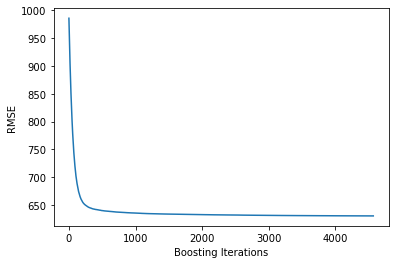

In [295]:
results = xgb_model.evals_result()
val_error = results['validation_0']['rmse']
print("Validation RMSE: {:.2f}".format(val_error[-1]))
plt.plot(range(len(val_error)), val_error)
plt.xlabel('Boosting Iterations')
plt.ylabel('RMSE')
plt.show()

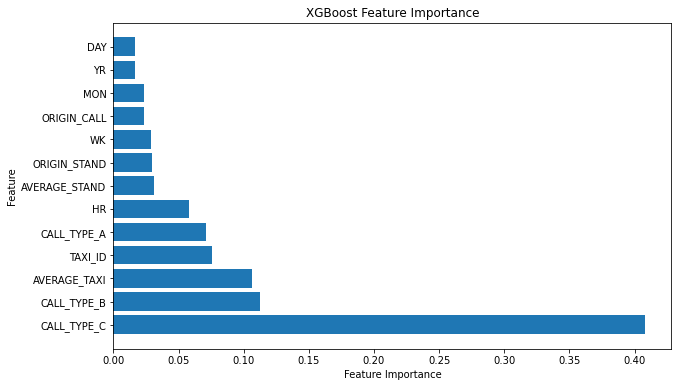

In [296]:
importance_scores = xgb_model.feature_importances_
sorted_indices = importance_scores.argsort()[::-1]
sorted_importances = importance_scores[sorted_indices]
feature_names = [features[i] for i in sorted_indices]
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_importances)), sorted_importances, tick_label=feature_names)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('XGBoost Feature Importance')
plt.show()

In [ ]:
train_loss = results['validation_0']['rmse']
df_tr = df_tr.sample(frac=1, random_state=42)
train_indices = X_train[:, 0]
df_train_samples = df_tr.loc[train_indices]
top_loss_indices = np.argsort(train_loss)[::-1][:10]

plt.figure(figsize=(8, 6))
for i, index in enumerate(top_loss_indices):
    polyline_string = df_tr.at[index, "POLYLINE"]
    polyline = ast.literal_eval(polyline_string)
    lon_lat = np.array(polyline).T
    lon = lon_lat[0]
    lat = lon_lat[1]
    plt.plot(lon, lat, marker='o')

# Create the legend using the RMSE loss values
legend_labels = [f"Sample {i+1} (Loss: {train_loss[i]:.2f})" for i in top_loss_indices]
plt.legend(legend_labels)

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Trips with Highest Training Loss')
plt.show()

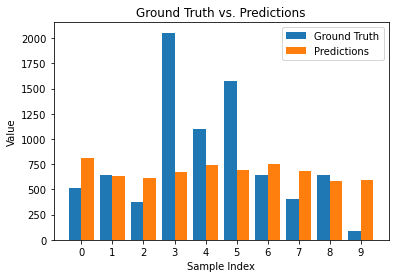

In [301]:
y_pred = xgb_model.predict(X_train)

# Specify the number of samples to visualize
num_samples = 10

# Randomly select indices for the samples
random_indices = np.random.choice(len(X_train), size=num_samples, replace=False)

# Obtain the randomly selected samples and corresponding ground truth values
selected_samples = X_train[random_indices]
selected_targets = y_train[random_indices]
selected_predictions = y_pred[random_indices]

# Create an array for the x-axis positions
x_positions = np.arange(num_samples)

# Plot the ground truth and predicted values as bars
plt.bar(x_positions, selected_targets, width=0.4, align='center', label='Ground Truth')
plt.bar(x_positions + 0.4, selected_predictions, width=0.4, align='center', label='Predictions')

# Set the x-axis ticks and labels
plt.xticks(x_positions + 0.2, x_positions)
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.title('Ground Truth vs. Predictions')
plt.legend()

# Show the bar graph
plt.show()


# Test Data

In [297]:
# loading test data
data = pd.read_csv("test_public.csv")

In [298]:
# applying transformations
data[["YR", "MON", "DAY", "HR", "WK"]] = data[["TIMESTAMP"]].apply(parse_time, axis=1, result_type="expand")
# data['AVERAGE_CALL'] = data['CALL_TYPE'].map(average_len_by_call_type)
data = pd.get_dummies(data, columns=['CALL_TYPE'], prefix=['CALL_TYPE'])
#data['TAXI_ID'] = data['TAXI_ID'].astype(str).str[-3:].astype(int)
# data['START_LOG'] = data['POLYLINE'].apply(lambda x: eval(x)[0][0])
# data['START_LAT'] = data['POLYLINE'].apply(lambda x: eval(x)[0][1])
# data['END_LOG'] = data['POLYLINE'].apply(lambda x: eval(x)[-1][0])
# data['END_LAT'] = data['POLYLINE'].apply(lambda x: eval(x)[-1][1])
#polyline_samples = []
# for _, row in df_sample.sample(n=len(data), replace=False).iterrows():
#     if not pd.isnull(row['ORIGIN_STAND']):
#         stand_id = int(row['ORIGIN_STAND'])
#         meta_row = meta[meta['ID'] == stand_id].iloc[0]
#         polyline = [meta_row['Longitude'], meta_row['Latitude']]
#     else:
#         polyline = ast.literal_eval(row['POLYLINE'])[0]
#     polyline_samples.append(polyline)
# data['START_POS'] = polyline_samples
# for index, row in data.iterrows():
#     initial_coords = [float(coord) for coord in row['START_POS']]
#     min_distance = float('inf')
#     closest_stand_id = None
#     for meta_index, meta_row in meta.iterrows():
#         lon = float(meta_row['Longitude'])
#         lat = float(meta_row['Latitude'])
#         distance = calculate_haversine_distance(initial_coords[0], initial_coords[1], lon, lat)
#         if distance < min_distance:
#             min_distance = distance
#             closest_stand_id = meta_row['ID']
#     if pd.isna(data.loc[index, 'ORIGIN_STAND']):
#         data.loc[index, 'ORIGIN_STAND'] = closest_stand_id
# data['START_DISTANCE'] = data.apply(lambda row: calculate_haversine_distance(row['START_LOG'],
#                                                                                         row['START_LAT'],
#                                                                                         city_center[0],
#                                                                                         city_center[1]), axis=1) 
data['ORIGIN_CALL_MISSING'] = data['ORIGIN_CALL'].isna().astype(int)
data['ORIGIN_STAND_MISSING'] = data['ORIGIN_STAND'].isna().astype(int)
# data['ORIGIN_CALL'].fillna(0, inplace=True)
# data['ORIGIN_STAND'].fillna(0, inplace=True)
data['AVERAGE_TAXI'] = data['TAXI_ID'].map(average_len_by_taxiID)
data['AVERAGE_STAND'] = data['ORIGIN_STAND'].map(average_len_by_standID)

# data['SIN_HR_ANG'],  data['COS_HR_ANG']= encode_hour(data['HR'])
# data['SIN_MON_ANG'],  data['COS_MON_ANG']= encode_hour(data['MON'])
# data['SIN_DAY_ANG'],  data['COS_DAY_ANG']= encode_hour(data['DAY'])
# data['SIN_WK_ANG'],  data['COS_WK_ANG']= encode_hour(data['WK'])



# data['AVERAGE_HR'] = data['HR'].map(average_len_by_HR)
# data['TIME_OF_DAY'] = data['HR'].apply(categorize_hour)
# data['TIME_OF_DAY'] = data['TIME_OF_DAY'].astype('category')
# data = pd.get_dummies(data, columns=['TIME_OF_DAY'], prefix='', prefix_sep='')
# data['DAY_TYPE'] = data.apply(lambda row: get_day_category(row['DAY'], row['MON'],row['YR']), axis=1)
# data = pd.get_dummies(data, columns=['DAY_TYPE'], prefix='', prefix_sep='')
# data["EVENING"] = 0

In [299]:
X_test2 = data[features].values
#concatenated_column = pd.concat([data[column] for column in features], axis=1)
y_pred2 = xgb_model.predict(X_test2)

In [300]:
# writing predicition to csv
df = pd.read_csv("sampleSubmission.csv")

df["TRAVEL_TIME"] = y_pred2

df.to_csv("my_pred.csv", index=None)

In [304]:
model_filename = 'xgb_model.pkl'
with open(model_filename, 'wb') as file:
    pickle.dump(xgb_model, file)